In [10]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import os, glob
import numpy as np
import datetime as dt
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.stem.lancaster import LancasterStemmer
pd.set_option('display.max_colwidth', None)

date = datetime.now().strftime("%Y-%m-%d")
firstdateoftheyear = datetime(int(datetime.now().strftime("%Y")), 1,1).strftime("%Y-%m-%d")
lastweek = (dt.date.today() + dt.timedelta(days=-dt.date.today().weekday()) - dt.timedelta(days = 7)).strftime("%Y-%m-%d")
excludem = '^tokocrypto$|^indodax$|^pintu_id$|^pintuid$|^rekeningkuasset$|^rekuid$|^reku_id$|^kripto$|^crypto$'

In [11]:
def stopword(x):
  factory = StopWordRemoverFactory()
  swsas = factory.get_stop_words()
  swnltk = stopwords.words(['english','indonesian'])
  sw = [\
        '1','2','3','4','5','6','7','8','9','0',\
        'kripto','crypto',\
        'bikin','biar','udah','kalo','kalo','gue','sih','emang','mohon','pake','en','dah','tau','zipmex',\
        'zipmexindonesia','gimana','loh','sampe','banget','kah','ga',\
        'asetmasadepan','cmc','aplikasipintu','salamtothemoon','deh', 'dm','hi', 'hai', 'kakak',\
        'pintuid','rekeningku','zipmex', 'pintu', 'upbit', 'tokocrypto','indodax', 'ya','token',\
        'ceo','tkolock','crypto','lock','udh','dont', 'hey', 'baby','rt', 'tuh','amp','sir','tko',\
        'bos','aja','gak','nih','nya','min','ud','cm','kak','bang','ntar','yg','nii', 'utc', 'x']+ swnltk\
        + list(STOPWORDS) + list(x[x['Type'].str.contains("Mention|Hashtag")]["word"].unique())
  swdf = pd.DataFrame(sw).drop_duplicates()
  swdf.columns = ["word"]
  swdf['word'] = swdf['word'].str.replace('[^\w\s]','', regex=True)
  return swdf

In [12]:
# topik = input("Pilih topik")
# date_begin = input("Pilih tanggal mulai (YYYY-MM-DD)")
# date_end = input("Pilih tanggal selesai (YYYY-MM-DD)")
# limit = input("berapa banyak data?")
# language = input("select lang:")

In [13]:
topik = "kripto crypto"
date_begin = firstdateoftheyear
date_end = date
limit = 1000
language = "in en"
langs = language.split()

tweets_list1 = []
tweets_list2 = []
for i in langs:
    query = f"{topik} since:{date_begin} until:{date_end} lang:{i}"

    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'{query}').get_items()):
        if i>int(limit):
            break
        tweets_list1.append(tweet)
        tweets_list2.append([tweet.url, tweet.user.followersCount, tweet.user.friendsCount, tweet.user.verified])
        
    # Creating a dataframe from the tweets list above
    tl1 = pd.DataFrame(tweets_list1)
    tl2 = pd.DataFrame(tweets_list2,\
            columns = ['url', 'followers', 'friends', 'verified'])

    data = pd.merge(tl1, tl2, on = 'url')

    data.rename(columns = {'rawContent': 'text', 'sourceLabel':'source (platform)',\
        'replyCount':'replied','retweetCount':'retweeted','quoteCount':'quoted',\
        'likeCount':'liked', 'inReplyToTweetId': 'reply to'}, inplace=True)

    data['reply to'] = data['reply to'].fillna(0).apply(np.int64).apply(str).replace("0","")
    data['post type'] = np.where(data['quotedTweet'].notnull()==True, "share",\
        np.where((data['reply to']!="") & (data['quotedTweet'].isnull()==True),"reply","post"))

    data = data[['date', 'url','text', 'lang', 'source (platform)', 'verified', 'post type', 'reply to',\
        'replied','retweeted', 'quoted', 'liked', 'followers', 'friends']]
    # return data

In [14]:
wordings = data.copy()

wordings['word'] = wordings['text'].str.lower()\
    .str.replace('#|#\n',' #', regex=True).str.replace('@|@\n',' @', regex=True)\
    .str.split()
wordings = wordings.explode('word')
wordings = wordings[~(wordings['word'].str.contains('https'))]
wordings['word'] = wordings['word'].str.replace('[^A-Za-z #@]',' ', regex=True)
wordings = wordings[wordings['word'].str.contains(" ")==False]
wordings['Type'] = np.where(wordings['word'].str.startswith("#"), "hashtag",\
    np.where(wordings['word'].str.contains("@"), "mention", "word"))

swdf = stopword(wordings)
st = LancasterStemmer()
factory = StemmerFactory()
indo = factory.create_stemmer()

wordings_new = pd.merge(wordings, swdf, how='outer', on = 'word', indicator=True).drop_duplicates()
wordings_new['word'] = np.where((wordings_new['lang']=='en') & (wordings_new['Type']=="word"), wordings_new['word'].apply(lambda y: st.stem(y)),\
    np.where((wordings_new['lang']=='in') & (wordings_new['Type']=="word"), wordings_new['word'].apply(lambda y: indo.stem(y)),wordings_new['word']))
wordings_new = wordings_new[(wordings_new['_merge'] == 'left_only')].drop(columns="_merge")
hashnmention_new = wordings[(wordings['Type'] != 'word') & ~(wordings['word'].str.replace('@|#','', regex=True).str.contains(excludem))]

ov_wordings_word = wordings_new[(wordings_new['Type']=="word")].\
    groupby(['word']).count().add_prefix('count_').reset_index()[['word','count_url']]
ov_wordings_word.columns = ['word', 'count_word']
ov_wordings_total = wordings_new[(wordings_new['Type']=="word")].\
    groupby(['word']).sum(numeric_only=True).add_prefix('sum_').reset_index()

ov_wordings = pd.merge(ov_wordings_total,ov_wordings_word).sort_values(by='word', ascending=False)\
    [['word','count_word', 'sum_retweeted', 'sum_quoted', 'sum_liked']]

ov_wordings.rename(columns = {'count_word':'total word',\
    'sum_retweeted':'retweeted','sum_quoted':'quoted',\
    'sum_liked':'liked'}, inplace=True)

ov_hash_total = hashnmention_new[(hashnmention_new['Type']=="hashtag")].\
    groupby(['word']).sum(numeric_only=True).add_prefix('sum_').reset_index()[['word', 'sum_retweeted', 'sum_quoted', 'sum_liked']]

ov_hash_word = hashnmention_new[(hashnmention_new['Type']=="hashtag")].\
    groupby(['word']).count().add_prefix('count_').reset_index()[['word', 'count_url']]
ov_hash_word.columns = ['word', 'count_word']

ov_hash = pd.merge(ov_hash_total,ov_hash_word).sort_values(by='count_word', ascending=False)\
    [['word', 'count_word', 'sum_retweeted', 'sum_quoted', 'sum_liked']]

ov_hash['word'] = ov_hash['word'].replace("#","", regex=True)

ov_hash.rename(columns = {'word': 'hashtag', 'count_word':'total hashtags',\
    'sum_retweeted':'retweeted','sum_quoted':'quoted',\
    'sum_liked':'liked'}, inplace=True)

ov_mention_total = hashnmention_new[(hashnmention_new['Type']=="mention")].\
    groupby(['word']).sum(numeric_only=True).add_prefix('sum_').reset_index()[['word', 'sum_retweeted', 'sum_quoted', 'sum_liked']]

ov_mention_word = hashnmention_new[(hashnmention_new['Type']=="mention")].\
    groupby(['word']).count().add_prefix('count_').reset_index()[['word', 'count_url']]
ov_mention_word.columns = ['word', 'count_word']

ov_mention = pd.merge(ov_mention_total,ov_mention_word).sort_values(by='count_word', ascending=False)\
    [['word', 'count_word', 'sum_retweeted', 'sum_quoted', 'sum_liked']]

ov_mention['word'] = ov_mention['word'].replace("@","", regex=True)

ov_mention.rename(columns = {'word': 'mention', 'count_word':'total mentions',\
    'sum_retweeted':'retweeted','sum_quoted':'quoted',\
    'sum_liked':'liked'}, inplace=True)

# return wordings_new, hashnmention_new, ov_wordings, ov_hash, ov_mention

In [15]:
ov_wordings.sort_values(by='total word', ascending = False).head(10)

,word,total word,retweeted,quoted,liked
3124,top,196,83.0,2.0,262.0
2025,mov,192,11.0,3.0,109.0
1270,hour,190,444.0,17.0,842.0
2556,report,189,10.0,0.0,97.0
196,aset,178,64.0,10.0,229.0
367,bitcoin,141,19.0,3.0,176.0
1383,investasi,106,40.0,2.0,98.0
1214,harga,92,19.0,5.0,104.0
308,beli,92,19.0,2.0,68.0
464,buy,82,537.0,57.0,4360.0


In [16]:
ov_hash.sort_values(by='total hashtags', ascending = False).head(10)

,hashtag,total hashtags,retweeted,quoted,liked
127,bitcoin,674,1449,48,5060
167,btc,529,6377,160,18202
270,cryptocurrency,458,1027,97,7887
120,binance,413,1658,70,4300
390,eth,368,4563,88,8782
391,ethereum,324,1458,38,3760
149,bnb,260,496,34,3847
140,blockchain,243,64,10,385
616,kriptopara,238,160,4,1241
1009,trading,203,24,4,238


In [17]:
ov_mention.sort_values(by='total mentions', ascending = False).head(10)

,mention,total mentions,retweeted,quoted,liked
298,sekolahkriptoid,34,1,0,24
231,missteencrypto,15,0,0,0
72,coinfessions,15,0,0,0
80,cryptohayes,15,0,0,0
40,binance,10,15,1,25
156,hoteliercrypto,10,1,1,4
354,watcherguru,7,6,0,20
355,wearesaitama,7,1,0,4
284,richquack,7,1877,38,3341
114,elonmusk,7,0,0,13


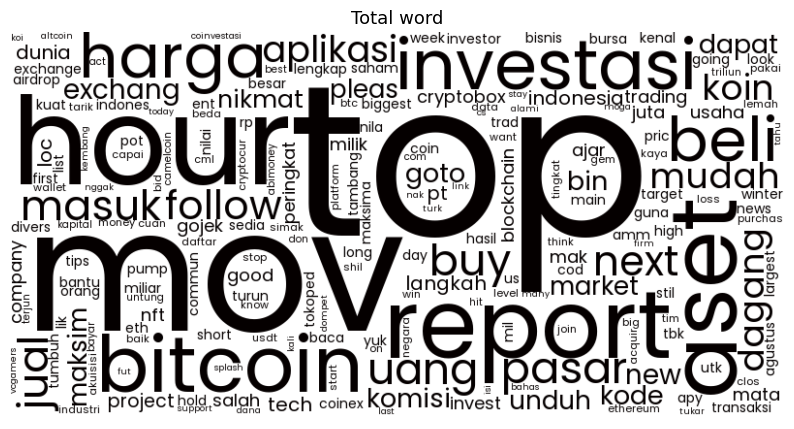

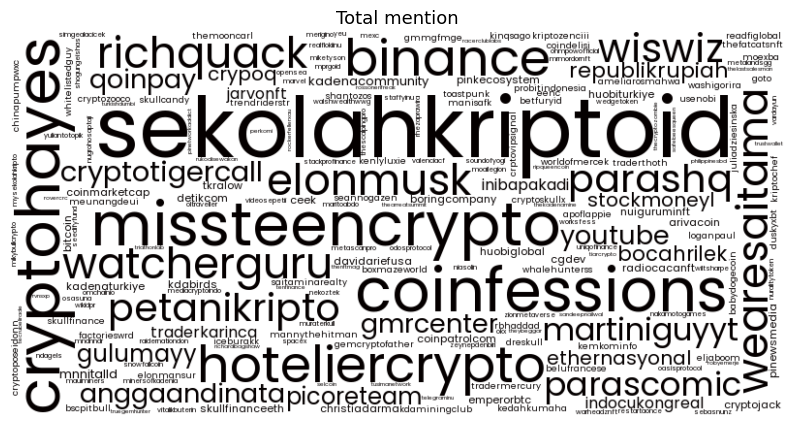

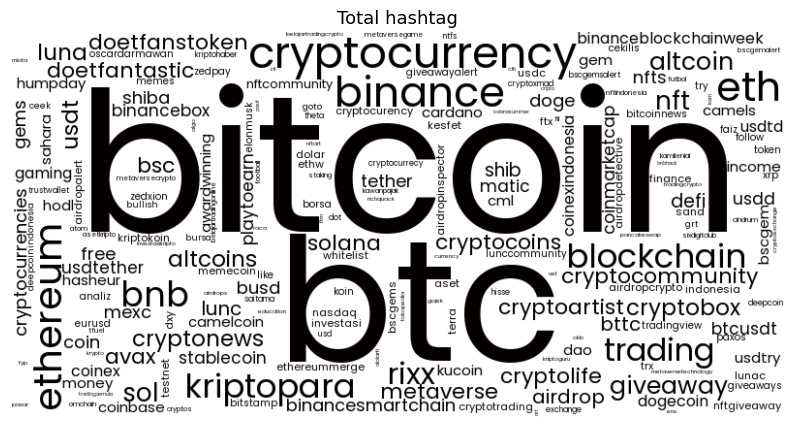

In [18]:
def black(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

def green(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(125, 62%, 37%)")

def blue(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(240,100%,50%)")

def white(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 100%)")

font = 'D:/Documents/Programming/Python/Sentiments/Sources/Font/Poppins-Regular.ttf'
words_max = 200

ov_wordings_dict = ov_wordings.set_index('word').to_dict()['total word']
wc = WordCloud(font_path = font, width=800, height=400, max_words=words_max, background_color="white").\
    generate_from_frequencies(ov_wordings_dict).recolor(color_func = black)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.title("Total word", fontsize=13)
plt.axis('off')
plt.show()

ov_mention_dict = ov_mention.set_index('mention').to_dict()['total mentions']
wc = WordCloud(font_path = font, width=800, height=400, max_words=words_max, background_color="white").\
    generate_from_frequencies(ov_mention_dict).recolor(color_func = black)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.title("Total mention", fontsize=13)
plt.axis('off')
plt.show()

ov_hash_dict = ov_hash.set_index('hashtag').to_dict()['total hashtags']
wc = WordCloud(font_path = font, width=800, height=400, max_words=words_max, background_color="white").\
    generate_from_frequencies(ov_hash_dict).recolor(color_func = black)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.title("Total hashtag", fontsize=13)
plt.axis('off')
plt.show()